# 인공지능과 가위바위보 하기[프로젝트]

## 라이브러리 버전 확인

In [1]:
# 라이브러리 버전 확인
import tensorflow as tf
import numpy as np

print(tf.__version__)
print(np.__version__)

2.17.1
1.26.4


## 데이터 준비

### 웹캠을 이용하여 가위바위보 데이터 만들기
---
https://teachablemachine.withgoogle.com/

- 각자 가위, 바위, 보 이미지를 100장씩 찍은다음 이미지를 같은 조원들과 공유함.
- 같은 조원 중에 한 사람의 이미지를 test데이터로 하고, 나머지 조원들의 이미지를 train데이터로 함.

### 데이터 불러오기 + Resize 하기
- 가위바위보 이미지를 불러와 28*28크기로 만들기. 이를 위해 PIL 라이브러리 사용

In [2]:
# PIL라이브러리 불러오기
from PIL import Image
import glob
import os

print("PIL 라이브러리 import 완료")

PIL 라이브러리 import 완료


In [3]:
# 구글 드라이브와 연동
from google.colab import drive
drive.mount('/content/drive')

# 파일 경로 수정
import os
print('os.getcwd():',os.getcwd())
os.chdir('/content/drive/MyDrive/Colab Notebooks/08_Deep_Learning/rock_scissors_paper')
print('os.getcwd():',os.getcwd())

Mounted at /content/drive
os.getcwd(): /content
os.getcwd(): /content/drive/MyDrive/Colab Notebooks/08_Deep_Learning/rock_scissors_paper


In [4]:
# 이미지의 사이즈를 변경하는 함수 정의
def resize_images(img_path):
  images = glob.glob(img_path + "/*.jpg")

  print(len(images), "image to be resized")

  target_size = (28, 28)

  for img in images:
    old_img = Image.open(img)
    new_img = old_img.resize(target_size, Image.Resampling.LANCZOS)
    # new_img = old_img.resize(target_size, Image.ANTIALIAS)  사라진 코드
    new_img.save(img, "JPEG")

  print(len(images), " images resized")

- 참고: `ANTIALIAS` was removed in Pillow 10.0.0 (after being deprecated through many previous versions). Now you need to use `PIL.Image.LANCZOS` or `PIL.Image.Resampling.LANCZOS`.

In [6]:
# 가위 이미지가 저장된 디렉토리 아래의 모든 jpg 파일을 읽어들이기
image_dir_path = os.getcwd() + '/train/scissors'
resize_images(image_dir_path)

print("가위 이미지 resize 완료!")

300 image to be resized
300  images resized
가위 이미지 resize 완료!


In [7]:
# 바위 이미지가 저장된 디렉토리 아래의 모든 jpg 파일을 읽어들이기
image_dir_path = os.getcwd() + '/train/rock'
resize_images(image_dir_path)

print("바위 이미지 resize 완료!")

300 image to be resized
300  images resized
바위 이미지 resize 완료!


In [8]:
# 보 이미지가 저장된 디렉토리 아래의 모든 jpg 파일을 읽어들이기
image_dir_path =  os.getcwd() + '/train/paper'
resize_images(image_dir_path)

print("보 이미지 resize 완료!")

300 image to be resized
300  images resized
보 이미지 resize 완료!


## 가위바위보 라벨링
---
- `load_data()`라는 함수를 만들어 가위바위보 데이터를 읽을 수 있게 함
- `가위:0, 바위:1, 보:2`로 라벨링

In [10]:
import numpy as np

def load_data(img_path, number_of_data=900):   # number_of_data: 가위바위보 데이터의 총 합
    # 가위 : 0, 바위 : 1, 보 : 2
    img_size=28
    color=3
    imgs=np.zeros(number_of_data*img_size*img_size*color,dtype=np.int32).reshape(number_of_data,img_size,img_size,color)
    labels=np.zeros(number_of_data,dtype=np.int32)

    idx=0
    for file in glob.iglob(img_path+'/scissors/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=0   # 가위 : 0
        idx=idx+1

    for file in glob.iglob(img_path+'/rock/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=1   # 바위 : 1
        idx=idx+1

    for file in glob.iglob(img_path+'/paper/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=2   # 보 : 2
        idx=idx+1

    print("학습데이터(x_train)의 이미지 개수는", idx,"입니다.")
    return imgs, labels

image_dir_path = os.getcwd() + '/train'
(x_train, y_train)=load_data(image_dir_path)
x_train_norm = x_train/255.0   # 입력은 0~1 사이의 값으로 정규화

print("x_train shape: {}".format(x_train.shape))
print("y_train shape: {}".format(y_train.shape))

학습데이터(x_train)의 이미지 개수는 900 입니다.
x_train shape: (900, 28, 28, 3)
y_train shape: (900,)


라벨:  0


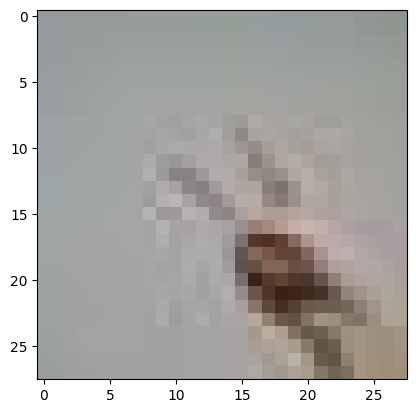

In [11]:
import matplotlib.pyplot as plt

plt.imshow(x_train[0])
print('라벨: ', y_train[0])

## 모델생성 및 검증데이터 불러오기
- **Sequential API**를 사용하여 모델 생성

In [14]:
import tensorflow as tf
from tensorflow import keras
import numpy as np

# model 생성
n_channel_1 = 16
n_channel_2 = 32
n_dense = 128

model = keras.models.Sequential()
model.add(keras.layers.Conv2D(n_channel_1, (3,3), activation='relu', input_shape=(28,28,3)))
model.add(keras.layers.MaxPool2D(2,2))
model.add(keras.layers.Conv2D(n_channel_2, (3,3), activation='relu'))
model.add(keras.layers.MaxPool2D((2,2)))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(n_dense, activation='relu'))
model.add(keras.layers.Dense(3, activation='softmax'))

model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)                    │ (None, 26, 26, 16)          │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 13, 13, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 11, 11, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 5, 5, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 800)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │         102,528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 3)                   │             387 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 108,003 (421.89 KB)

 Trainable params: 108,003 (421.89 KB)

 Non-trainable params: 0 (0.00 B)

- 모델을 `fit()`할 때 사용할 validation데이터로 `x_test`, `y_test`데이터 불러오기

In [15]:
# x_test, y_test데이터 불러오기
image_dir_path = os.getcwd() + "/test/scissors"
resize_images(image_dir_path)

image_dir_path = os.getcwd() + "/test/rock"
resize_images(image_dir_path)

image_dir_path = os.getcwd() + "/test/paper"
resize_images(image_dir_path)

image_dir_path = os.getcwd() + "/test"
(x_test, y_test) = load_data(image_dir_path, 300)

x_test_norm = x_test/255.0   # 입력은 0~1 사이의 값으로 정규화
print("x_test shape: {}".format(x_test.shape))
print("y_test shape: {}".format(y_test.shape))

100 image to be resized
100  images resized
100 image to be resized
100  images resized
100 image to be resized
100  images resized
학습데이터(x_train)의 이미지 개수는 300 입니다.
x_test shape: (300, 28, 28, 3)
y_test shape: (300,)


## 모델학습 및 성능 평가
- 모델을 학습과정에 `history`에 저장
- 시각화하여 train데이터에서와 test데이터에서의 **손실함수값과 정확도**비교

In [16]:
# 모델 학습 및 평가
model.compile(optimizer='rmsprop',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(x_train, y_train,
                    epochs=40,
                    batch_size=512,
                    validation_data=(x_test, y_test))

Epoch 1/40
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 456ms/step - accuracy: 0.3213 - loss: 46.1905 - val_accuracy: 0.3333 - val_loss: 85.1637
Epoch 2/40
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step - accuracy: 0.3647 - loss: 78.0803 - val_accuracy: 0.3333 - val_loss: 16.0795
Epoch 3/40
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step - accuracy: 0.3370 - loss: 17.8013 - val_accuracy: 0.3333 - val_loss: 25.4586
Epoch 4/40
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step - accuracy: 0.3349 - loss: 24.5636 - val_accuracy: 0.3333 - val_loss: 4.3212
Epoch 5/40
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step - accuracy: 0.3645 - loss: 6.9560 - val_accuracy: 0.3300 - val_loss: 4.6482
Epoch 6/40
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 283ms/step - accuracy: 0.4579 - loss: 4.1562 - val_accuracy: 0.4167 - val_loss: 2.8598
Epoch 7/40
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 264ms/step - accuracy: 0.4738 - loss: 2.4269 - val_accuracy: 0.4133 - val_loss: 2.5630
Epoch 8/40
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 284ms/step - accuracy: 0.5055 - loss: 1.9672 - val_accuracy: 0.4133 - va

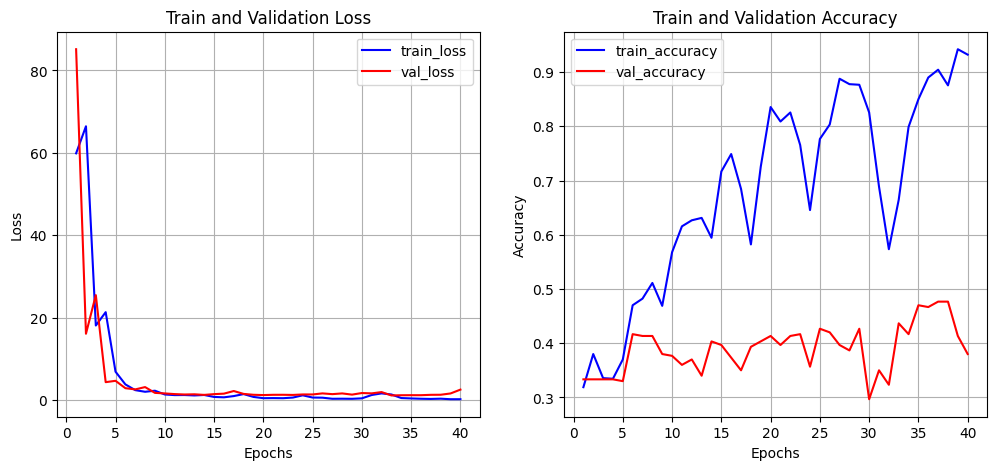

In [17]:
# 모델의 학습과정 시각화
import matplotlib.pyplot as plt

history_dict = history.history

loss = history_dict['loss']
val_loss = history_dict['val_loss']
epochs = range(1, len(loss)+1)

fig = plt.figure(figsize=(12, 5))

ax1 = fig.add_subplot(1, 2, 1)
ax1.plot(epochs, loss, color='blue', label='train_loss')
ax1.plot(epochs, val_loss, color='red', label='val_loss')
ax1.set_title('Train and Validation Loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.grid()
ax1.legend()

accuracy = history_dict['accuracy']
val_accuracy = history_dict['val_accuracy']

ax2 = fig.add_subplot(1, 2, 2)
ax2.plot(epochs, accuracy, color='blue', label='train_accuracy')
ax2.plot(epochs, val_accuracy, color='red', label='val_accuracy')
ax2.set_title('Train and Validation Accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.grid()
ax2.legend()

plt.show()

In [23]:
print(f'train데이터에서 loss: {np.round(loss[-1], 3)}')
print(f'test데이터에서 loss: {np.round(val_loss[-1], 3)}\n')
print(f'train데이터에서 accuracy: {np.round(accuracy[-1], 3)}')
print(f'train데이터에서 accuracy: {np.round(val_accuracy[-1], 3)}')

train데이터에서 loss: 0.18
test데이터에서 loss: 2.511

train데이터에서 accuracy: 0.932
train데이터에서 accuracy: 0.38


- train데이터와 test데이터에서 loss값의 차이가 거의 없으므로 과대적합되었다고 보기는 어렵다.
- epochs가 커질수록 train데이터에서 accuracy가 일정하게 증가하는 형태를 보이지 않는 것으로 보아 모델 학습이 제대로 이루어졌다고 보기 어렵다.